<a href="https://colab.research.google.com/github/lejohnyjohn6/contacts_over_time/blob/master/pkt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
import json
import random as rd
from copy import deepcopy
from scipy.special import gamma

%matplotlib inline

In [2]:
GOOGLE_COLAB = True
if GOOGLE_COLAB:
    from google.colab import drive 
    drive.mount('/content/drive')
    my_path = '/content/drive/My Drive/Epidemiology/Copenhagen Networks Study/'
    os.chdir(my_path)
    DATA_DIR = "./"
else:
    DATA_DIR = './'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

The [Bluetooh dataset](https://www.nature.com/articles/s41597-019-0325-x) contains 4 columns: <br>
 - **timestamp**: Timestamp in seconds from the beginning of the observation period (as reported by the device. Note, that because of differences in the internal clock of different devices, some of the measurements will not be perfectly aligned.)
 - **user A** : ID of one user (ego).
 - **user B** : ID of the other user (alter). 0–850 for participants of the study, −1 for empty scans, −2 for any non-participating device
 - **received signal strength indication (rssi)** : Received Signal Strength Indication, measured in dBm, a rough proxy for distance between devices (the higher the absolute value, the higher the distance)

**Summary**: 5,474,289 records, 706 total users

Notes:
 - Empty scans are marked with user B = -1 and RSSI = 0
 - Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.


In [0]:
# Import data
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename)) 
data = LoadData("bt_symmetric.csv", DATA_DIR + 'Data/')

In [5]:
# Visualize first contacts
data.head(5)

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


In [0]:
# Visualize last contacts
data.tail(5)

,# timestamp,user_a,user_b,rssi
5474284,2418900,702,371,-79
5474285,2418900,703,-1,0
5474286,2418900,704,-1,0
5474287,2418900,705,-2,-90
5474288,2418900,707,-2,-53


In [0]:
# Some statistics
data.rename(columns={"# timestamp": "timestamp"}, inplace=True)

print("Time length of the study:", round((data.iloc[-1]['timestamp']+1)/(60*60*24)), "days")
initial_timestamp = data.iloc[0]['timestamp']
final_timestamp = data.iloc[-1]['timestamp']
timestamps = list(data.timestamp.unique())

print('Number of scans:', data.shape[0])
print('Number of users who participated to the study:', len(data.user_a.unique()))
print('Number of interactions:', data[(data.user_b == -2)|(data.user_b > -1)].shape[0])
print('Ratio # interactions user-user/user-OutOfStudyIndividual:', round(data[data.user_b > -1].shape[0]/data[data.user_b == -2].shape[0], 3))

Time length of the study: 28.0 days
Number of scans: 5474289
Number of users who participated to the study: 706
Number of interactions: 3254153
Ratio # interactions user-user/user-OutOfStudyIndividual: 2.931


# Data processing



In [0]:
times = range(1, 28)

In [0]:
def BuildBluetoothNetwork(df_bt, nx_build=True, timestamp=None, user_index=-3):
  """ 
  Uses temporal data to build bluetooth network.
  
  df_bt: raw bluetooth data
  nx_build: True to return the built network, else False
  timestamp: If specified, build network for this specific timestamp (snapshot)
  user_index: If specified, build network for this specific user

  """

  if user_index >= 0: # Restrict data to specific user if needed.
    dt = df_bt[df_bt.user_a == user_index]
  else:
    dt = df_bt

  if nx_build and timestamp != None: # Build network snapshot at given timestamp.
    G = nx.Graph()
    # In-study users (id >= 0) at given timestamp.
    in_study_users_at_timestamp = dt[(dt['timestamp'] == timestamp)
                                      & (dt['user_b'] >= 0)][[
                                          'user_a', 'user_b', 'rssi']]
    # Build an undirected network of the in-study users.
    for row in in_study_users_at_timestamp.itertuples():
      user_a = row[1]
      user_b = row[2]
      rssi = row[3]
      G.add_edge(user_a, user_b, weight=rssi)
    # Return raw data and graph built. 
    return dt, G
  
  elif nx_build and timestamp == None: # Build aggregate of all network snapshots.
    G = nx.Graph()
    G.add_node(user_index)
    degree_t = {}
    # In-study users (id >= 0).
    in_study_users = dt[dt['user_b'] >= 0]
    if in_study_users.shape[0] == 0: # No contact with in-study users.
      return dt, G, degree_t
    # Build an undirected network of the in-study users time after time.
    if user_index >= 0: # Restrict data to specific user if needed.
      for time in timestamps: 
        df_time = in_study_users[in_study_users.timestamp == time]
        for row in df_time.itertuples():
          user_b = row[3]
          G.add_edge(user_index, user_b)
        degree_t[time] = G.degree[user_index]
      return dt, G, degree_t

    else: # Use data from all in-study users.
      for row in in_study_users.itertuples():
          user_a = row[2]
          user_b = row[3]
          rssi = row[4]
          G.add_edge(user_a, user_b, weight=rssi)
      return dt, G
    
  else: 
    return dt

## Retain in-study users' degrees over time

In [0]:
users = sorted(list(data.user_a.unique()))
user_degree_over_time = {}
final_user_degree = {}
for user in users:
  print("user", user)
  df, G, degree_t = BuildBluetoothNetwork(data[data.user_b > -1], nx_build=True, timestamp=None, user_index=user)
  user_degree_over_time[user] = degree_t
  if len(degree_t) == 0:
    final_user_degree[user] = 0
  else: 
    final_user_degree[user] = degree_t[timestamps[-1]]
in_study_final_degrees = {str(k): final_user_degree[k] for k in final_user_degree.keys()}

In [0]:
user_degrees_over_time_str = {str(k): user_degree_over_time[k] for k in user_degree_over_time.keys()}
in_study_degrees_over_time = {}
for key in user_degrees_over_time_str:
  in_study_degrees_over_time[key] = {str(k): user_degrees_over_time_str[key][k] for k in user_degrees_over_time_str[key].keys()}

In [0]:
# Save files
#with open(DATA_DIR + 'Data/in_study_final_degrees.json', 'w') as gp:
#    json.dump(in_study_final_degrees, gp)
#with open(DATA_DIR + 'Data/in_study_degrees_over_time.json', 'w') as hp:
#    json.dump(in_study_degrees_over_time, hp)

## Index users

In [0]:
# Discard users with no in-study contacts
users_to_discard = [] 
for key in in_study_final_degrees:
  if  in_study_final_degrees[key] == 0:
    users_to_discard += [key]
for key in users_to_discard:
  del in_study_final_degrees[key]
  del in_study_degrees_over_time[key]

In [0]:
# Re-index users
users = list(in_study_final_degrees.keys())
index_matching = {}
count = 1
for user in users:
  index_matching[str(count)] = user
  count += 1

In [0]:
# Save files
#with open(DATA_DIR + 'Data/user_index.json', 'w') as gp:
#    json.dump(users, gp)
#with open(DATA_DIR + 'Data/index_matching.json', 'w') as gp:
#    json.dump(index_matching, gp)

## Retain out-of-study users' degrees over time
**Extrapolation**: From the in-study degree $\textit{isd}$ of the user at the end of the study, i.e. the number of in_study users contacts were made with, and the total number of contacts with them $\textit{isc}$ (multiple contacts with the same individual generally), we estimate, for each in-study user, the average number of contacts made with one individual over the course of the study $\alpha = \frac{\textit{isd}}{\textit{isc}}$. We use this ratio to estimate the number of out-of-study users encountered.

In [0]:
# Estimate ratio # contacts / # of different contacts
contact_ratios = {}
for user in users:
  final_in_study_degree = in_study_final_degrees[user]
  number_in_study_contacts = data[(data.user_a == int(user)) & (data.user_b > -1)].shape[0]
  contact_ratios[user] = final_in_study_degree/number_in_study_contacts

#with open(DATA_DIR + 'Data/contact_ratios.json', 'w') as gp:
#    json.dump(contact_ratios, gp)

In [0]:
# Estimate out of study number of different contact per day
out_study_degrees_over_time = {}
out_study_final_degrees = {}
for user in users:
  print('\n', user)
  user_ratio = contact_ratios[user]
  user_data = data[(data.user_a == int(user)) & (data.user_b == -2)]
  user_dict = {}
  for time in times: 
    user_dict[str(time*60*60*24)] = user_data[user_data.timestamp <= time*60*60*24].shape[0] * user_ratio
  out_study_degrees_over_time[user] = user_dict
  out_study_final_degrees[user] = user_dict[str(times[-1]*60*60*24)]

#with open(DATA_DIR + 'Data/out_study_degrees_over_time.json', 'w') as gp:
#    json.dump(out_study_degrees_over_time, gp)
#with open(DATA_DIR + 'Data/out_study_final_degrees.json', 'w') as gp:
#    json.dump(out_study_final_degrees, gp)

In [0]:
# Estimate total number of new contacts up to date
degrees_over_time = {}
final_degrees = {}
for user in users:
  print('\n', user)
  user_dict = {}
  for time in times: 
    user_dict[str(time*60*60*24)] = out_study_degrees_over_time[user][str(time*60*60*24)] + in_study_degrees_over_time[user][str(time*60*60*24)]
  degrees_over_time[user] = user_dict
  final_degrees[user] = user_dict[str(times[-1]*60*60*24)]

#with open(DATA_DIR + 'Data/degrees_over_time.json', 'w') as gp:
#    json.dump(degrees_over_time, gp)
#with open(DATA_DIR + 'Data/final_degrees.json', 'w') as gp:
#    json.dump(final_degrees, gp)

## First contact and scan times

In [0]:
# Detect first contact time for each user
first_contact_times = {}
for user in users:
  user_degrees = degrees_over_time[user]
  for time in times:
    if user_degrees[str(time*60*60*24)] >= 1:
      first_contact_times[user] = time
      break

#with open(DATA_DIR + 'Data/first_contact_times.json', 'w') as gp:
#    json.dump(first_contact_times, gp)

In [0]:
# Detect first scan time for each user
first_scan_times = {}
for user in user_index:
  first_scan_time = max(1, int(data[data.user_a == int(user)].iloc[0].timestamp / (60*60*24)))
  first_scan_times[user] = first_scan_time

#with open(DATA_DIR + 'Data/first_scan_times.json', 'w') as gp:
#    json.dump(first_scan_times, gp)

## Estimate $T_t$

In [0]:
times = range(1, 28)
total_contacts_over_time = {}
final_total_contacts = {}
for user in users:
  print('\n', user)
  user_data = data[(data.user_a == int(user)) & (data.user_b != -1)]
  user_dict = {}
  for time in times: 
    user_dict[str(time*60*60*24)] = user_data[user_data.timestamp <= time*60*60*24].shape[0]
  total_contacts_over_time[user] = user_dict
  final_total_contacts[user] = user_dict[str(times[-1]*60*60*24)]

#with open(DATA_DIR + 'Data/total_contacts_over_time.json', 'w') as gp:
#    json.dump(total_contacts_over_time, gp)
#with open(DATA_DIR + 'Data/final_total_contacts.json', 'w') as gp:
#    json.dump(final_total_contacts, gp)

# Analysis

## Import files

In [7]:
# Import files
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename)) 
data = LoadData("bt_symmetric.csv", DATA_DIR + 'Data/')
data.rename(columns={"# timestamp": "timestamp"}, inplace=True)

with open(DATA_DIR + 'Data/final_degrees.json') as json_file:
  final_degrees = json.load(json_file)
with open(DATA_DIR + 'Data/degrees_over_time.json') as json_file:
  degrees_over_time = json.load(json_file)
with open(DATA_DIR + 'Data/user_index.json') as json_file:
  user_index = json.load(json_file)
with open(DATA_DIR + 'Data/index_matching.json') as json_file:
  index_matching = json.load(json_file)
with open(DATA_DIR + 'Data/first_contact_times.json') as json_file:
  first_contact_times = json.load(json_file)
with open(DATA_DIR + 'Data/first_scan_times.json') as json_file:
  first_scan_times = json.load(json_file)
with open(DATA_DIR + 'Data/contact_ratios.json') as json_file:
  contact_ratios = json.load(json_file)
with open(DATA_DIR + 'Data/total_contacts_over_time.json') as json_file:
  total_contacts_over_time = json.load(json_file)
with open(DATA_DIR + 'Data/final_total_contacts.json') as json_file:
  final_total_contacts = json.load(json_file)


nb_users = len(user_index)
times = list(range(1, 28))
print("Ratio of users with contacts on the first day:",
      round(sum([first_contact_times[user] == 1 for user in user_index])/nb_users, 2))
print("Ratio of users with contacts on the first two days:",
      round(sum([first_contact_times[user] < 3 for user in user_index])/nb_users, 2))
print("Ratio of users with scans on the first day:",
      round(sum([first_scan_times[user] == 1 for user in user_index])/nb_users, 2))

Ratio of users with contacts on the first day: 0.66
Ratio of users with contacts on the first two days: 0.85
Ratio of users with scans on the first day: 0.9


## Degree distribution
The final (after 28 days of study) number of participants a participant has been in contact with.

In [0]:
def BuildBluetoothNetwork(df_bt, nx_build=True, timestamp=None, user_index=-3):
  """ 
  Uses temporal data to build bluetooth network.
  
  df_bt: raw bluetooth data
  nx_build: True to return the built network, else False
  timestamp: If specified, build network for this specific timestamp (snapshot)
  user_index: If specified, build network for this specific user

  """

  if user_index >= 0: # Restrict data to specific user if needed.
    dt = df_bt[df_bt.user_a == user_index]
  else:
    dt = df_bt

  if nx_build and timestamp != None: # Build network snapshot at given timestamp.
    G = nx.Graph()
    # In-study users (id >= 0) at given timestamp.
    in_study_users_at_timestamp = dt[(dt['timestamp'] == timestamp)
                                      & (dt['user_b'] >= 0)][[
                                          'user_a', 'user_b', 'rssi']]
    # Build an undirected network of the in-study users.
    for row in in_study_users_at_timestamp.itertuples():
      user_a = row[1]
      user_b = row[2]
      rssi = row[3]
      G.add_edge(user_a, user_b, weight=rssi)
    # Return raw data and graph built. 
    return dt, G
  
  elif nx_build and timestamp == None: # Build aggregate of all network snapshots.
    G = nx.Graph()
    G.add_node(user_index)
    degree_t = {}
    # In-study users (id >= 0).
    in_study_users = dt[dt['user_b'] >= 0]
    if in_study_users.shape[0] == 0: # No contact with in-study users.
      return dt, G, degree_t
    # Build an undirected network of the in-study users time after time.
    if user_index >= 0: # Restrict data to specific user if needed.
      for time in timestamps: 
        df_time = in_study_users[in_study_users.timestamp == time]
        for row in df_time.itertuples():
          user_b = row[3]
          G.add_edge(user_index, user_b)
        degree_t[time] = G.degree[user_index]
      return dt, G, degree_t

    else: # Use data from all in-study users.
      for row in in_study_users.itertuples():
          user_a = row[2]
          user_b = row[3]
          rssi = row[4]
          G.add_edge(user_a, user_b, weight=rssi)
      return dt, G
    
  else: 
    return dt

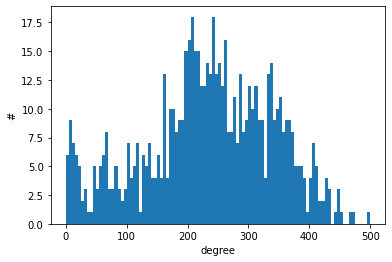

In [10]:
dt, G = BuildBluetoothNetwork(data, nx_build=True)
bins_list = range(0, 505, 5)
plt.hist([d for n, d in G.degree() if d > 2], bins=bins_list)
plt.ylabel('#')
plt.xlabel("degree")
#plt.savefig(DATA_DIR + 'Plots/Degree distribution.png')
plt.show()

## $P(K,t)$

In [0]:
def DistributionSamplingForT(T, sampling_iter=500, sampling_size=350, K_max=200):
  """ 
  Samples from the data and compute resulting mean, sd.
  
  T: day
  sampling_iter: number of sampling iterations 
  sampling_size: size of samples

  """
  means = []
  sds = []
  for it in range(sampling_iter):
    shares = [0 for i in range(K_max)]
    sample = rd.sample(range(1, nb_users+1), k=sampling_size)
    count = 0
    for instance in sample:
      user = index_matching[str(instance)]
      degree_user_T = int(degrees_over_time[str(user)][str(T*60*60*24)])
      if degree_user_T >= K_max:
        count += 1 
        continue
      shares[degree_user_T] += 1
    shares = [share/(sampling_size-count) for share in shares]
    mean = sum([index*shares[index] for index in range(K_max)])
    sd = np.sqrt(sum([(index**2)*shares[index] for index in range(K_max)]) - mean**2)
    means += [mean]
    sds += [sd] 

  return means, sds

In [0]:
K_max = 500

In [0]:
interval_length = 10

### PDF fitting

In [0]:
def ComputeDensityFunctionForT(T, K_range, interval_length):
  """ 
  Estimates probability of having K contacts at T.
  
  T: day
  K_range: range of K values.
  """

  sample = range(1, nb_users+1)
  counts = [0 for i in range(len(K_range))]
  discarded = 0
  for instance in sample:
    user = index_matching[str(instance)]
    degree_user_T = degrees_over_time[str(user)][str(T*60*60*24)]
    if degree_user_T > max(K_range):
      discarded += 1 
      continue
    index = int(degree_user_T // interval_length)
    counts[index] += 1
  counts = [count/(nb_users-discarded) for count in counts]

  return counts

In [0]:
density = {}
K_quality_check = range(0, K_max, interval_length)
for time in times:
  density[time] = ComputeDensityFunctionForT(time, K_range=K_quality_check, interval_length=interval_length)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


time 1 alpha 0.122 beta 0.03 mean 4.112 sd 11.775
time 2 alpha 0.535 beta 0.027 mean 19.621 sd 26.835
time 3 alpha 0.614 beta 0.021 mean 29.547 sd 37.721
time 4 alpha 0.918 beta 0.024 mean 38.887 sd 40.58
time 5 alpha 1.118 beta 0.024 mean 46.949 sd 44.395
time 6 alpha 1.215 beta 0.023 mean 54.013 sd 48.994
time 7 alpha 1.422 beta 0.025 mean 56.432 sd 47.325
time 8 alpha 1.534 beta 0.026 mean 59.107 sd 47.73
time 9 alpha 1.95 beta 0.029 mean 67.531 sd 48.359
time 10 alpha 2.061 beta 0.027 mean 76.81 sd 53.507
time 11 alpha 2.421 beta 0.028 mean 85.708 sd 55.082
time 12 alpha 2.735 beta 0.029 mean 95.666 sd 57.843
time 13 alpha 2.752 beta 0.025 mean 108.113 sd 65.169
time 14 alpha 2.734 beta 0.025 mean 111.153 sd 67.229
time 15 alpha 2.696 beta 0.024 mean 114.102 sd 69.495
time 16 alpha 2.817 beta 0.023 mean 120.736 sd 71.937
time 17 alpha 2.793 beta 0.022 mean 127.679 sd 76.399
time 18 alpha 2.814 beta 0.021 mean 132.397 sd 78.926
time 19 alpha 2.886 beta 0.02 mean 141.042 sd 83.03
tim

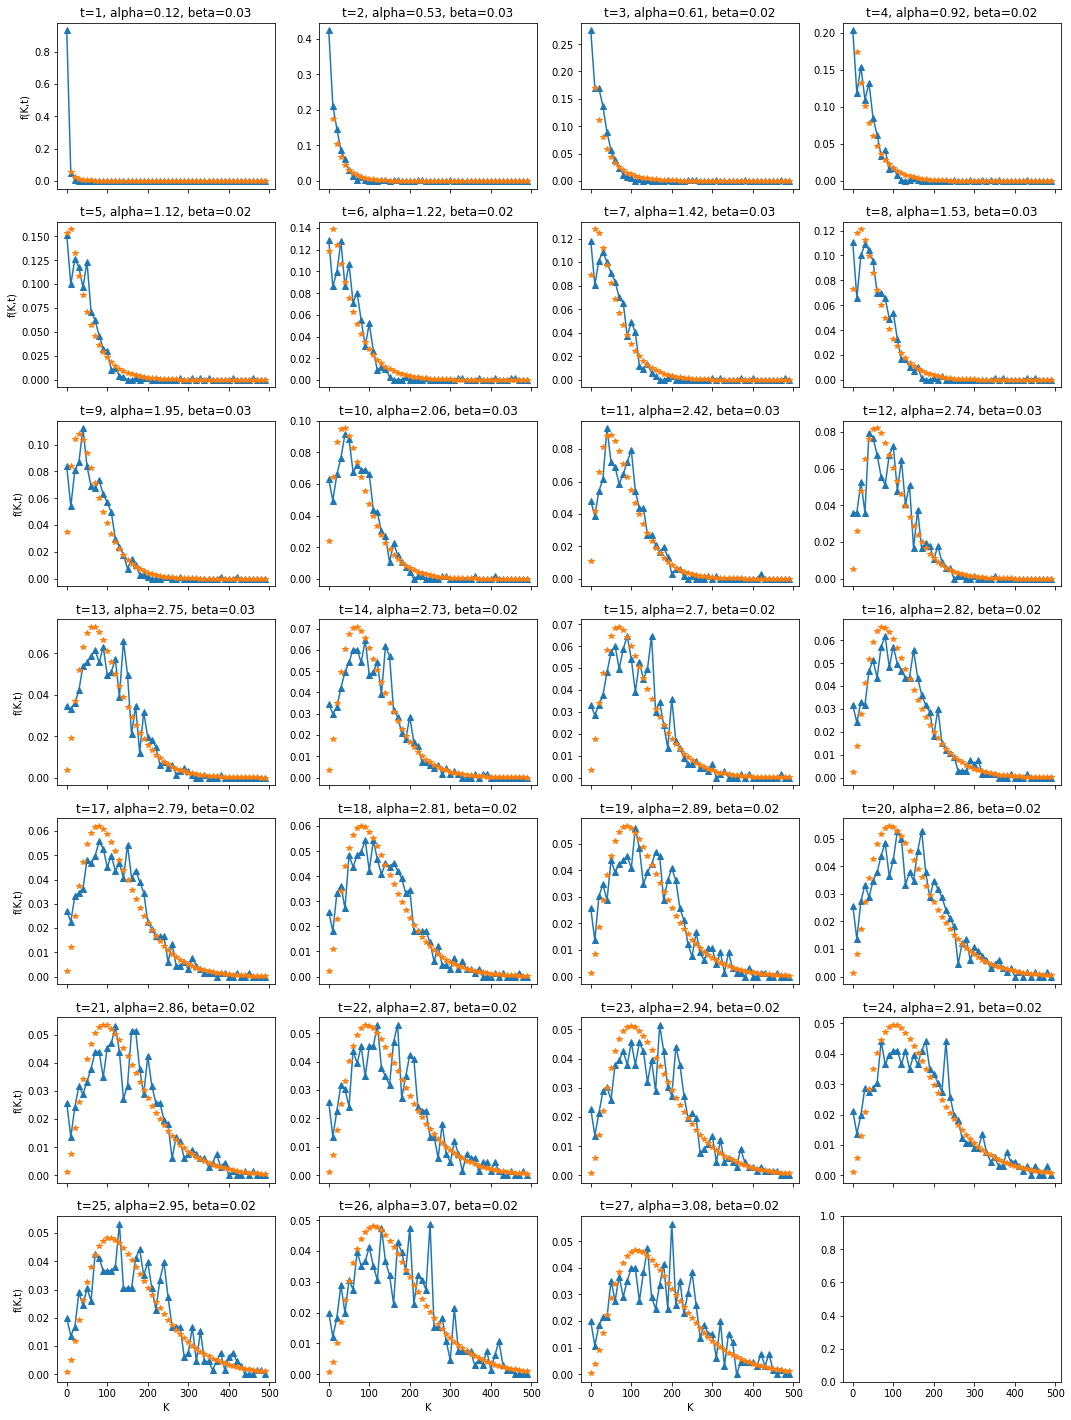

In [0]:
alphas = []
betas = []
mns = []
stds = []

fig, axs = plt.subplots(7, 4, sharex=True)
fig.set_size_inches(18, 25)
for time in times:
  mean, sd = DistributionSamplingForT(time, sampling_iter=1, sampling_size=nb_users, K_max=K_max)
  beta = mean[0]/(sd[0]**2)
  alpha = mean[0]*beta
  probs = []
  for occ in K_quality_check:
    prob = sum([(beta**alpha) * (number**(alpha-1)) * np.exp(-beta*number) / gamma(alpha) for number in range(occ, occ+interval_length)]) 
    probs += [prob]
  alphas += [alpha]
  betas += [beta]
  mns += [mean[0]]
  stds += [sd[0]]
  print('time', time, 'alpha', round(alpha,3), 'beta', round(beta, 3), 'mean', round(mean[0], 3), 'sd', round(sd[0], 3))

  ax = axs[(time-1)//4, (time-1)%4]
  ax.plot(K_quality_check, density[time], "-^")
  ax.plot(K_quality_check, probs, "*")
  ax.set_title('t={time}, alpha={alpha}, beta={beta}'.format(time=time, alpha=round(alpha,2), beta=round(beta,2)))
  if (time-1)%4 == 0:
    ax.set_ylabel('f(K,t)')
  if (time-1)//4 == 6:
    ax.set_xlabel('K') 
#fig.savefig(DATA_DIR + 'Plots/Curve_fitting.png')

Text(0.5, 0, 'time')

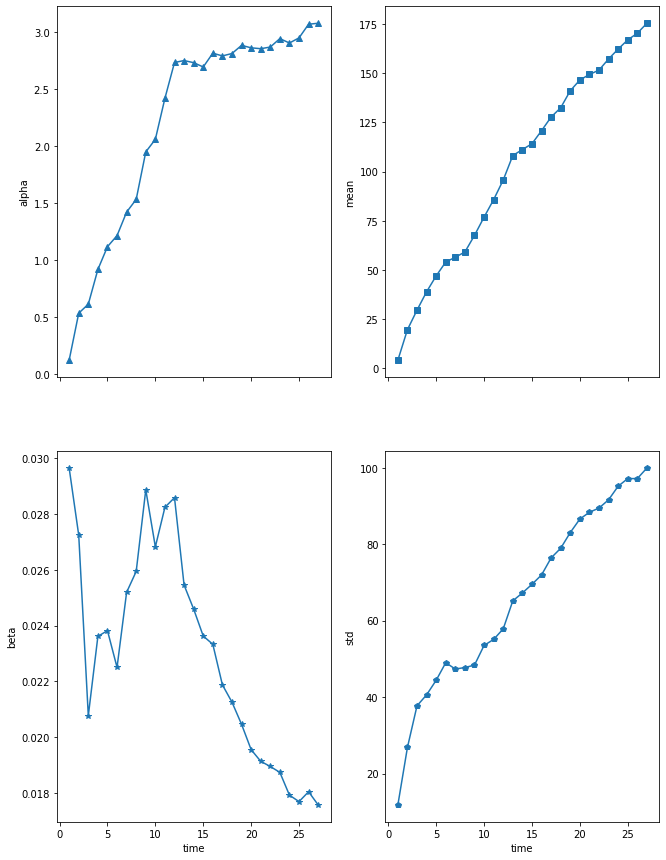

In [0]:
fig, axs = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(10.8, 15)

ax = axs[0, 0]
ax.plot(times, alphas, "-^")
ax.set_ylabel('alpha')

ax = axs[1, 0]
ax.plot(times, betas, "-*")
ax.set_ylabel('beta')
ax.set_xlabel('time')

ax = axs[0, 1]
ax.plot(times, mns, "-s")
ax.set_ylabel('mean')

ax = axs[1, 1]
ax.plot(times, stds, "-p")
ax.set_ylabel('std')
ax.set_xlabel('time')

#fig.savefig(DATA_DIR + 'Plots/Parameters_over_time.png')

a: 0.469
b: 17.711


Text(0, 0.5, 'std')

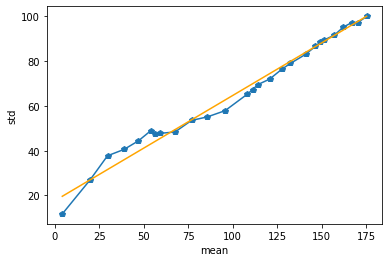

In [0]:
a = (stds[-1] - stds[1]) / (mns[-1] - mns[1])
b = sum([std - a*mn for mn, std in zip(mns, stds)]) / len(stds)
print('a:', round(a, 3))
print('b:', round(b, 3))

plt.plot(mns, stds, "-p")
plt.plot(mns, [a*mn + b for mn in mns], "-", color='orange')
plt.xlabel('mean')
plt.ylabel('std')
#plt.savefig(DATA_DIR + 'Plots/mean_sd_t.png')

Text(0, 0.5, 'beta_hat / beta')

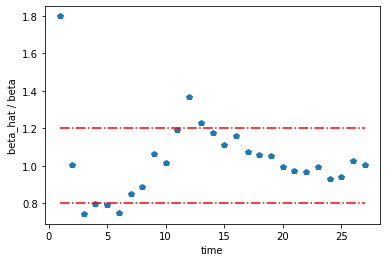

In [0]:
plt.plot(times, [beta/((np.sqrt(alpha) - a*alpha)/b) for alpha, beta in zip(alphas, betas)], 'p')
plt.plot(times, [0.80 for time in times], '-.r')
plt.plot(times, [1.20 for time in times], '-.r')
plt.xlabel("time")
plt.ylabel("beta_hat / beta")
#plt.savefig(DATA_DIR + 'Plots/beta_estimates.png')

## $(T_t, K_t)$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


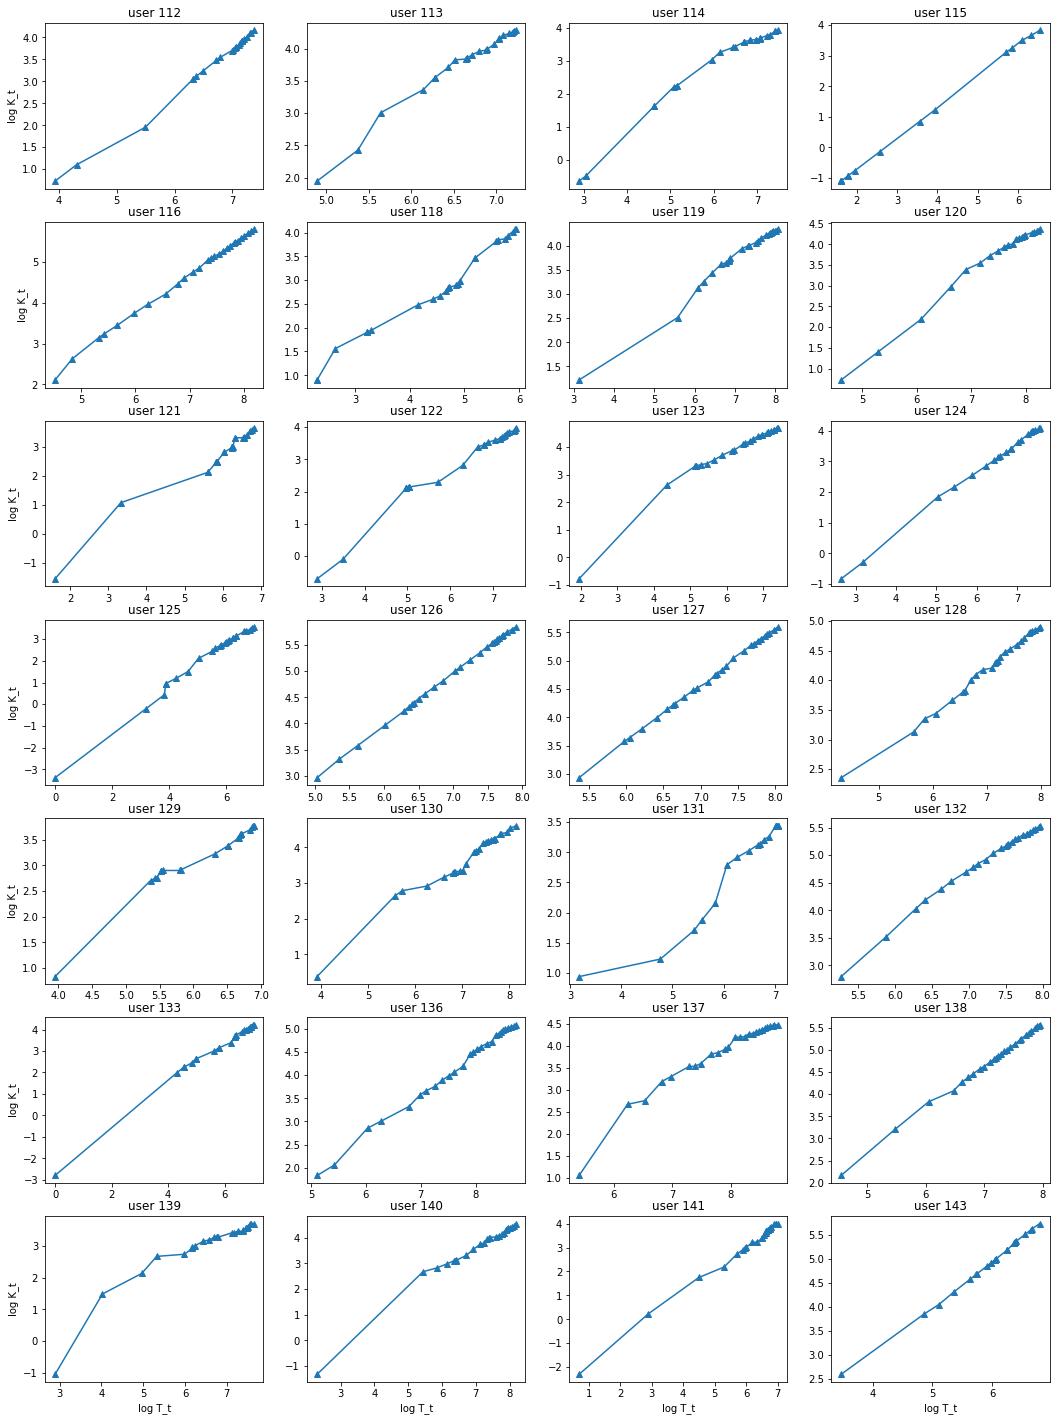

In [0]:
fig, axs = plt.subplots(7, 4)
fig.set_size_inches(18, 25)
count = 0
for user in user_index[100:128]: 
  contacts_user = total_contacts_over_time[user]
  degrees_user = degrees_over_time[user]
  ax = axs[count//4, count%4]
  ax.plot([np.log(contacts_user[key]) for key in contacts_user], [np.log(degrees_user[key]) for key in degrees_user], "-^")
  ax.set_title('user {}'.format(user))
  if count%4 == 0:
    ax.set_ylabel('log K_t')
  if count//4 == 6:
    ax.set_xlabel('log T_t') 
  count += 1
#fig.savefig(DATA_DIR + 'Plots/T_t_K_t.png')

# Appendix

## Cumulative distribution

In [0]:
Ks = [1,2,3,4] + list(range(5, 200, 5))

In [0]:
def ComputeCumulativeProbabilityForT(T, sampling_iter=10, sampling_size=100):
  """ 
  Estimates probability of having at least a number of contacts (K) within time window T.
  
  T: day
  sampling_iter: number of sampling iterations for K
  sampling_size: size of samples

  """
  probabilities = [0 for i in range(sampling_iter)]
  for it in range(sampling_iter):
    counts = [0 for i in range(len(Ks))]
    sample = rd.sample(range(1, nb_users+1), k=sampling_size)
    for index in range(len(Ks)):
      K = Ks[index]
      for instance in sample:
        user = index_matching[str(instance)]
        degree_user_T = degrees_over_time[str(user)][str(T*60*60*24)]
        if degree_user_T >= K:
          counts[index] += 1/sampling_size
      if counts[index] == 0:
        break
    probabilities[it] = counts

  return probabilities

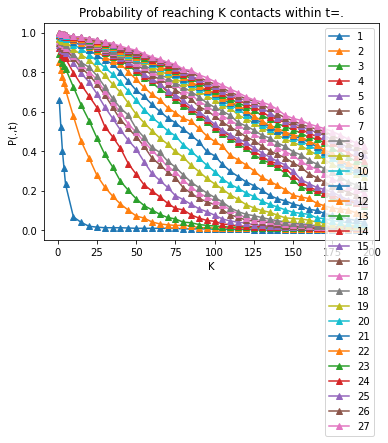

In [0]:
# All distributions
UNIVprobabilitiesT = {}
Tsampling_iter_UNIV = 1
Tsampling_size_UNIV = nb_users
for time in times:
  UNIVprobabilitiesT[time] = ComputeCumulativeProbabilityForT(time, sampling_iter=Tsampling_iter_UNIV, sampling_size=Tsampling_size_UNIV)

for time in times:
  probs = UNIVprobabilitiesT[time][0]
  #log_probs = [np.log(prob) for prob in probs]
  plt.plot(Ks, probs, "-^")
  plt.xlabel('K')
  plt.ylabel('P(.,t)')
plt.title('Probability of reaching K contacts within t=.')
plt.legend(times)
#plt.savefig()
plt.show()

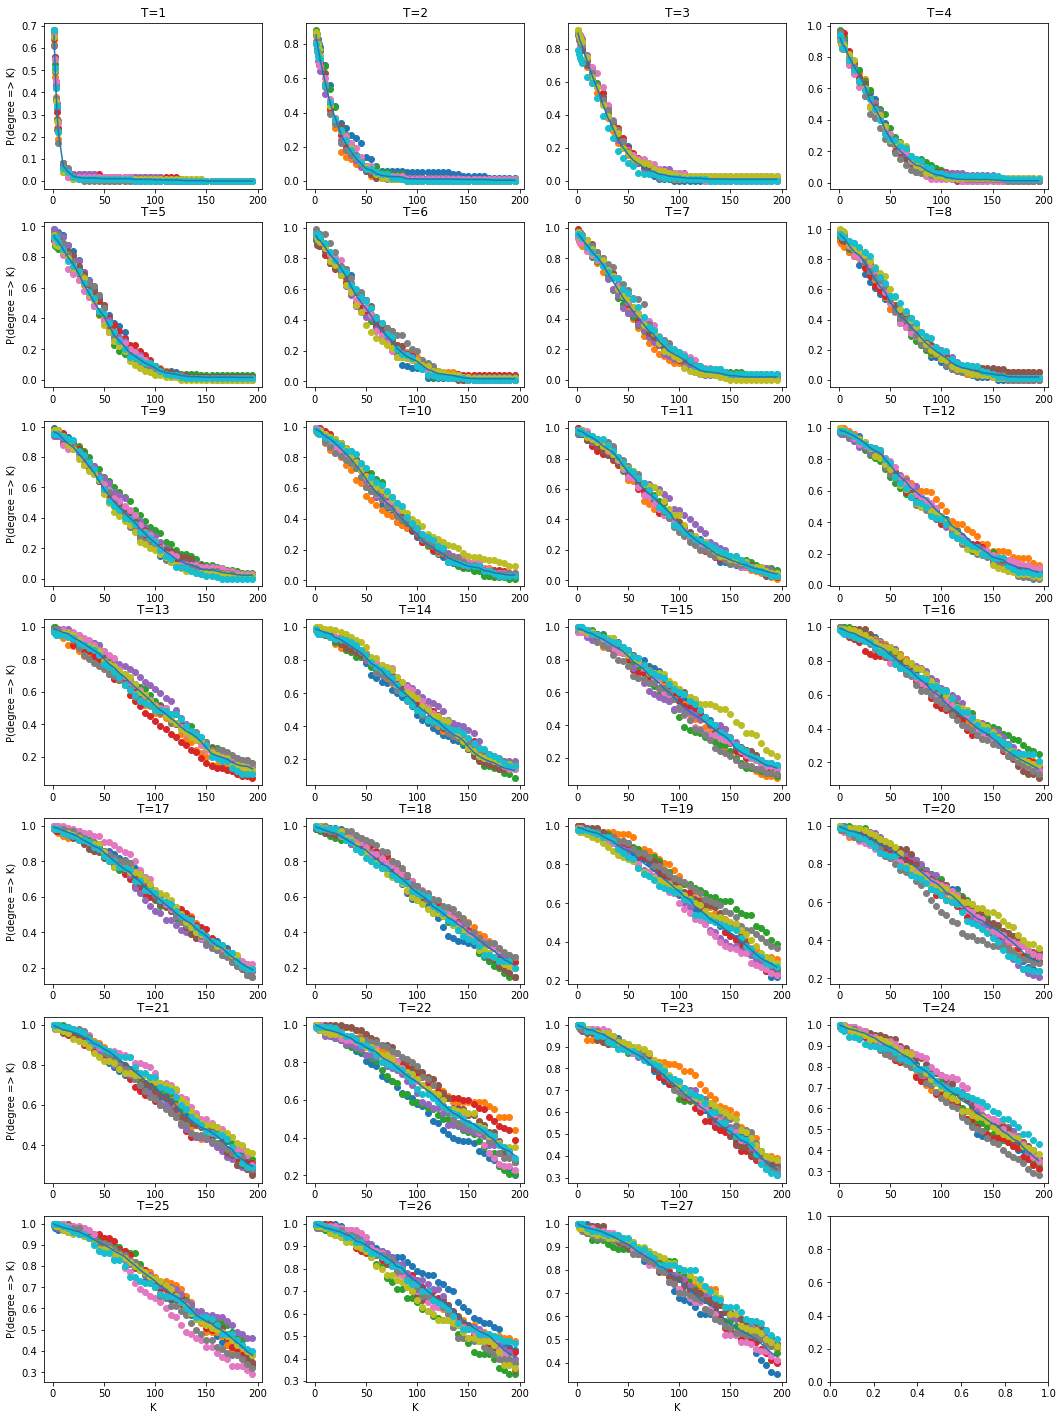

In [0]:
# Sampling for variance control
Tprobabilities = {}
sampling_iter_T = 10
sampling_size_T = 100
for time in times:
  Tprobabilities[time] = ComputeCumulativeProbabilityForT(time, sampling_iter=sampling_iter_T, sampling_size=sampling_size_T)

fig, axs = plt.subplots(7, 4)
fig.set_size_inches(18, 25)
for time in times:
  probs = Tprobabilities[time]
  ax = axs[(time-1)//4, (time-1)%4]
  ax.set_title('T={}'.format(time))
  for sample in range(sampling_iter_T):
    probs_sample = probs[sample]
    ax.scatter(Ks, probs_sample)
  probs_time = UNIVprobabilitiesT[time][0]
  ax.plot(Ks, probs_time)
  if (time-1)%4 == 0:
    ax.set_ylabel('P(degree => K)')
  if (time-1)//4 == 6:
    ax.set_xlabel('K')
#fig.savefig(DATA_DIR + 'Plots/Cumulative.png')

## Mean and standard deviation

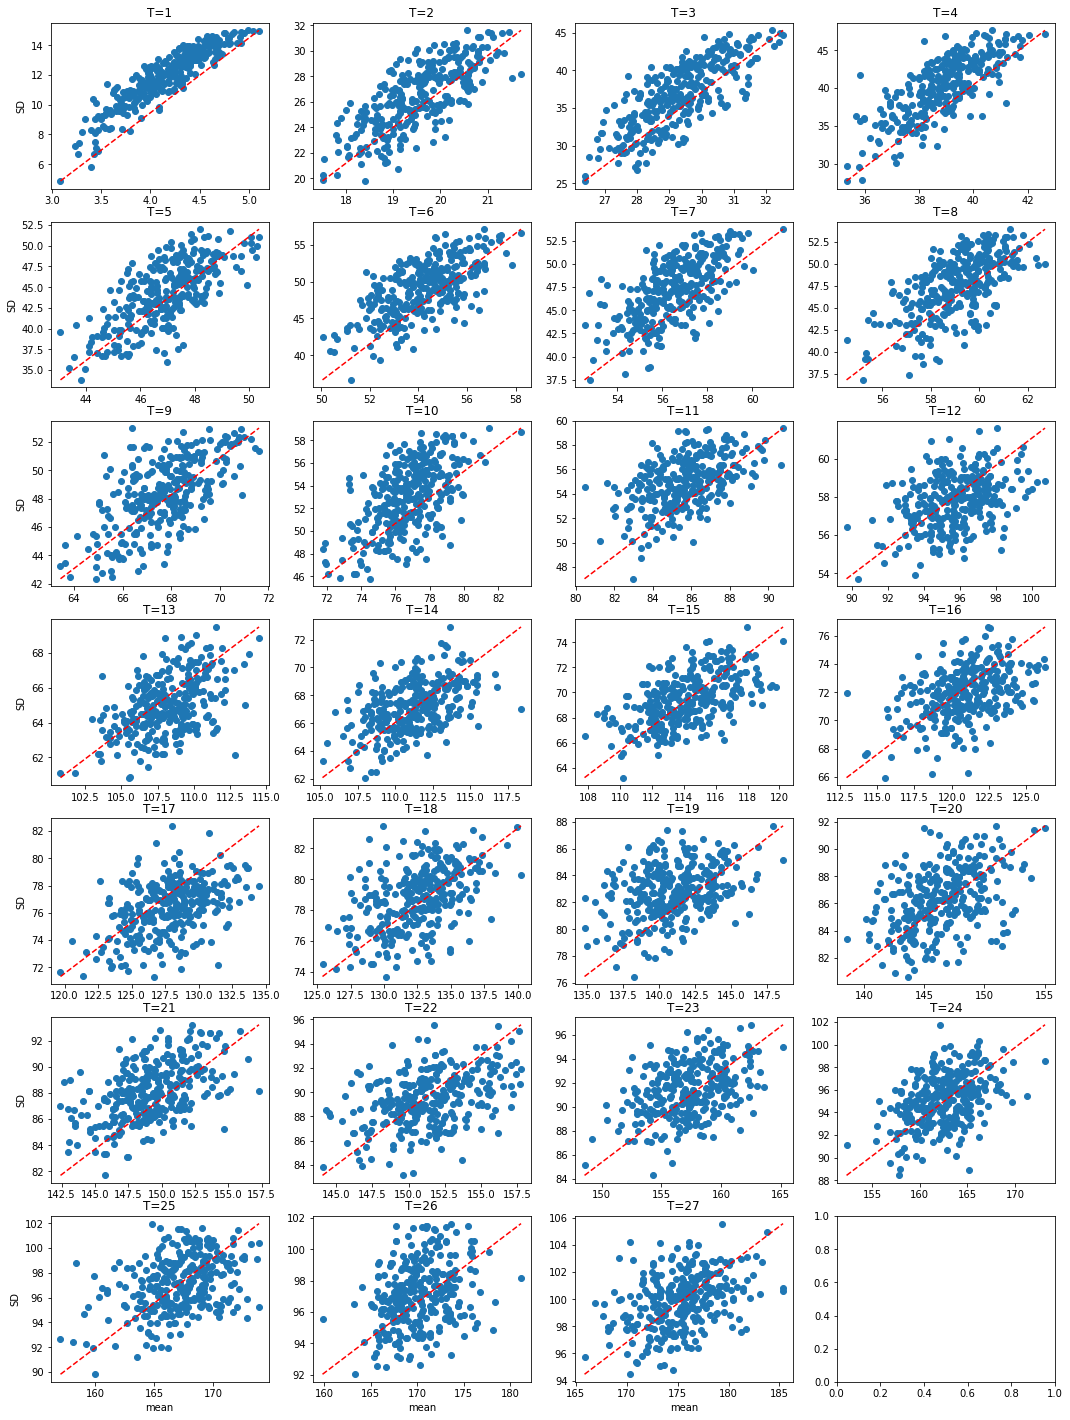

In [0]:
means = [0 for i in range(len(times))]
sds = [0 for i in range(len(times))]
for time in times:
  means[time-1], sds[time-1] = DistributionSamplingForT(time, sampling_iter=300, sampling_size=400, K_max=K_max)

fig, axs = plt.subplots(7, 4)
fig.set_size_inches(18, 25)
for time in times:
  ax = axs[(time-1)//4, (time-1)%4]
  max_x = max(means[time-1])
  min_x = min(means[time-1])
  max_y = max(sds[time-1])
  min_y = min(sds[time-1])
  ax.scatter(means[time-1], sds[time-1])
  ax.plot([min_x, max_x], [min_y, max_y], 'r--')
  ax.set_title('T={}'.format(time))
  if (time-1)%4 == 0:
    ax.set_ylabel('SD')
  if (time-1)//4 == 6:
    ax.set_xlabel('mean')
#fig.savefig(DATA_DIR + 'Plots/mean_sd.png')

## $(K_{t+1}, K_t)$

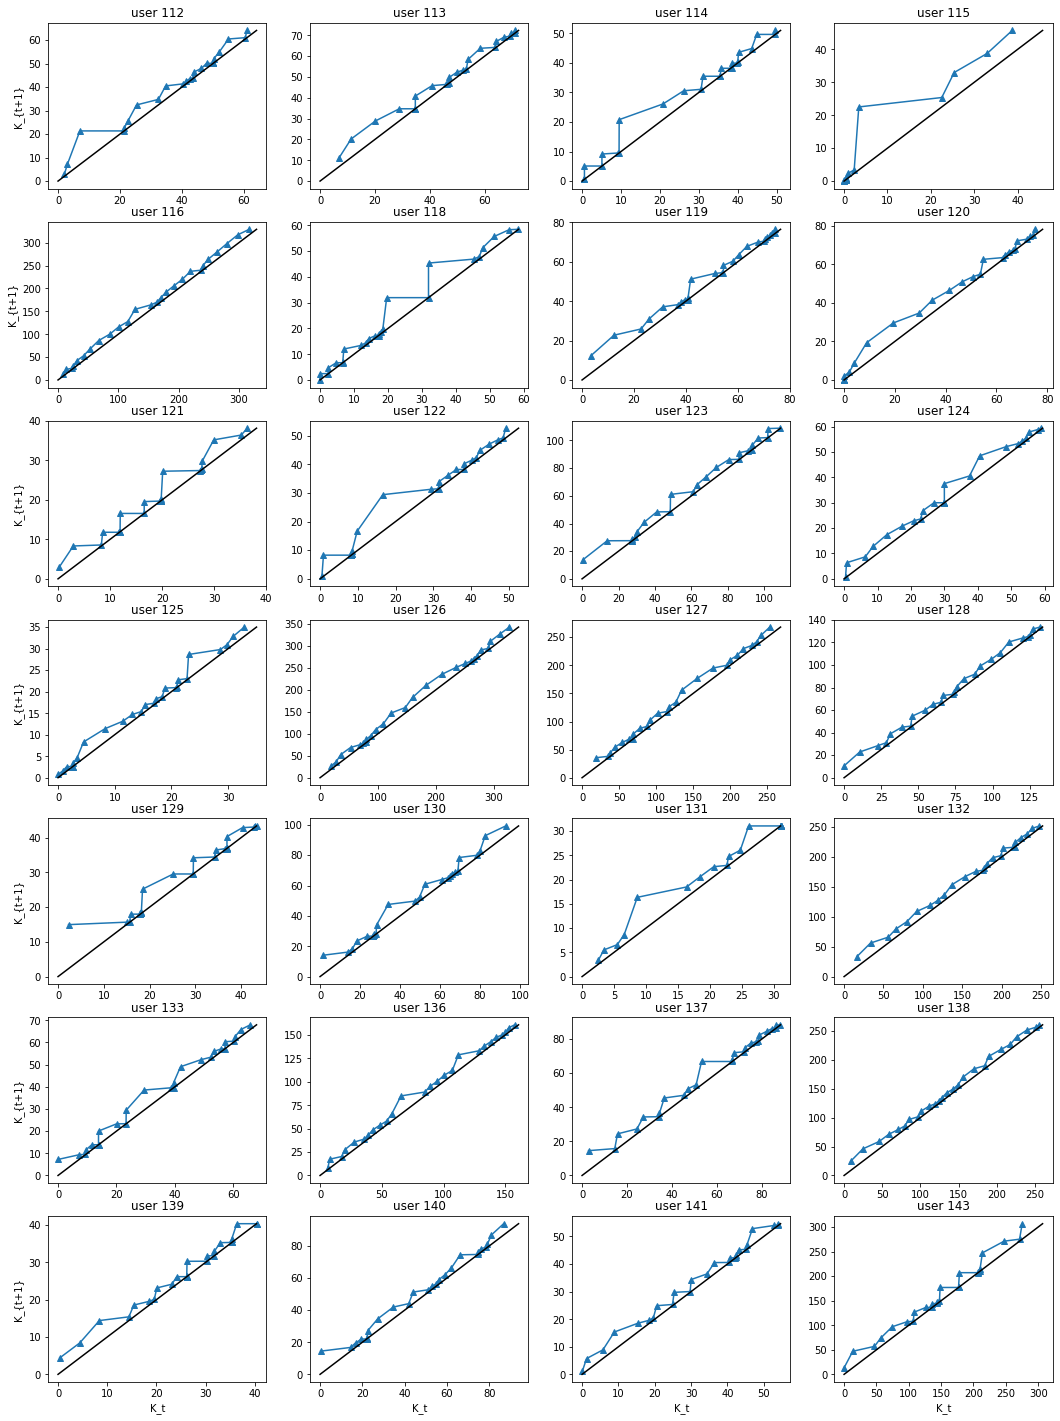

In [24]:
fig, axs = plt.subplots(7, 4)
fig.set_size_inches(18, 25)
count = 0
for user in user_index[100:128]: 
  degrees_user = degrees_over_time[user]
  ax = axs[count//4, count%4]
  ax.plot([degrees_user[key] for key in degrees_user][:-1], [degrees_user[key] for key in degrees_user][1:], "-^")
  ax.plot([0, [degrees_user[key] for key in degrees_user][-1]], [0, [degrees_user[key] for key in degrees_user][-1]], "-", color='black')
  ax.set_title('user {}'.format(user))
  if count%4 == 0:
    ax.set_ylabel('K_{t+1}')
  if count//4 == 6:
    ax.set_xlabel('K_t') 
  count += 1
#fig.savefig(DATA_DIR + 'Plots/K_t_K_t1.png')